In [1]:
# If using one or multiple GPUs
import os
os.environ["CUDA_VISIBLE_DEVICES"]=""

In [2]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import theano
import theano.tensor as T
import theano.sandbox.rng_mrg

import lasagne
from lasagne.layers import ReshapeLayer,Layer
from lasagne.init import Normal
from lasagne.regularization import regularize_layer_params_weighted, l2, l1
from lasagne.regularization import regularize_layer_params

ERROR (theano.gpuarray): Could not initialize pygpu, support disabled
Traceback (most recent call last):
  File "/home/james/anaconda3/envs/vizdoom/lib/python3.6/site-packages/theano/gpuarray/__init__.py", line 175, in <module>
    use(config.device)
  File "/home/james/anaconda3/envs/vizdoom/lib/python3.6/site-packages/theano/gpuarray/__init__.py", line 162, in use
    init_dev(device, preallocate=preallocate)
  File "/home/james/anaconda3/envs/vizdoom/lib/python3.6/site-packages/theano/gpuarray/__init__.py", line 65, in init_dev
    sched=config.gpuarray.sched)
  File "pygpu/gpuarray.pyx", line 614, in pygpu.gpuarray.init (pygpu/gpuarray.c:9419)
  File "pygpu/gpuarray.pyx", line 566, in pygpu.gpuarray.pygpu_init (pygpu/gpuarray.c:9110)
  File "pygpu/gpuarray.pyx", line 1021, in pygpu.gpuarray.GpuContext.__cinit__ (pygpu/gpuarray.c:13472)
pygpu.gpuarray.GpuArrayException: Unknown device error: -1


In [3]:
def load_model(filename):
    f=open(filename,'rb')
    params=pickle.load(f)
    f.close()
    return params

## Trial 19: FC size 128

In [4]:
batch_size = 1
time_context = 30
feat_size = 1025
input_shape=(batch_size,1,time_context,feat_size)
input_var = T.tensor4('inputs')
#scaled_tanh = lasagne.nonlinearities.ScaledTanH(scale_in=1, scale_out=0.5)
    
l_in_1 = lasagne.layers.InputLayer(shape=input_shape, input_var=input_var)

l_conv1 = lasagne.layers.Conv2DLayer(l_in_1, num_filters=30, filter_size=(1,30),stride=(1,4), pad='valid', nonlinearity=None)
l_conv1b= lasagne.layers.BiasLayer(l_conv1)

l_conv2 = lasagne.layers.Conv2DLayer(l_conv1b, num_filters=30, filter_size=(int(2*time_context/3),1),stride=(1,1), pad='valid', nonlinearity=None)
l_conv2b= lasagne.layers.BiasLayer(l_conv2)

l_fc=lasagne.layers.DenseLayer(l_conv2b,128)

l_fc11=lasagne.layers.DenseLayer(l_fc,l_conv2.output_shape[1]*l_conv2.output_shape[2]*l_conv2.output_shape[3])
l_reshape1 = lasagne.layers.ReshapeLayer(l_fc11,(batch_size,l_conv2.output_shape[1],l_conv2.output_shape[2], l_conv2.output_shape[3]))
l_inverse11=lasagne.layers.InverseLayer(l_reshape1, l_conv2)
l_inverse41=lasagne.layers.InverseLayer(l_inverse11, l_conv1)

l_fc12=lasagne.layers.DenseLayer(l_fc,l_conv2.output_shape[1]*l_conv2.output_shape[2]*l_conv2.output_shape[3])
l_reshape2 = lasagne.layers.ReshapeLayer(l_fc12,(batch_size,l_conv2.output_shape[1],l_conv2.output_shape[2], l_conv2.output_shape[3]))
l_inverse12=lasagne.layers.InverseLayer(l_reshape2, l_conv2)
l_inverse42=lasagne.layers.InverseLayer(l_inverse12, l_conv1)

l_fc13=lasagne.layers.DenseLayer(l_fc,l_conv2.output_shape[1]*l_conv2.output_shape[2]*l_conv2.output_shape[3])
l_reshape3 = lasagne.layers.ReshapeLayer(l_fc13,(batch_size,l_conv2.output_shape[1],l_conv2.output_shape[2], l_conv2.output_shape[3]))
l_inverse13=lasagne.layers.InverseLayer(l_reshape3, l_conv2)
l_inverse43=lasagne.layers.InverseLayer(l_inverse13, l_conv1)

l_fc14=lasagne.layers.DenseLayer(l_fc,l_conv2.output_shape[1]*l_conv2.output_shape[2]*l_conv2.output_shape[3])
l_reshape4 = lasagne.layers.ReshapeLayer(l_fc14,(batch_size,l_conv2.output_shape[1],l_conv2.output_shape[2], l_conv2.output_shape[3]))
l_inverse14=lasagne.layers.InverseLayer(l_reshape4, l_conv2)
l_inverse44=lasagne.layers.InverseLayer(l_inverse14, l_conv1)

l_merge=lasagne.layers.ConcatLayer([l_inverse41,l_inverse42,l_inverse43,l_inverse44],axis=1)

l_out = lasagne.layers.NonlinearityLayer(lasagne.layers.BiasLayer(l_merge), nonlinearity=lasagne.nonlinearities.rectify)

In [5]:
model = "../../results/trial_19/models/model_CNNbach10.pkl"
params = load_model(model)
lasagne.layers.set_all_param_values(l_out, params)

In [6]:
get_grads = []
for l in [l_inverse41, l_inverse42, l_inverse43, l_inverse44]:
    pred = lasagne.layers.get_output(l, deterministic=True)
    cost = lasagne.objectives.squared_error(pred, np.zeros(l.output_shape)).sum()
    #all_params = lasagne.layers.get_all_params(l_out)
    #all_grads = T.grad(cost, all_params)
    grad = theano.grad(cost, input_var)
    get_grads.append(theano.function([input_var], grad, allow_input_downcast=True))

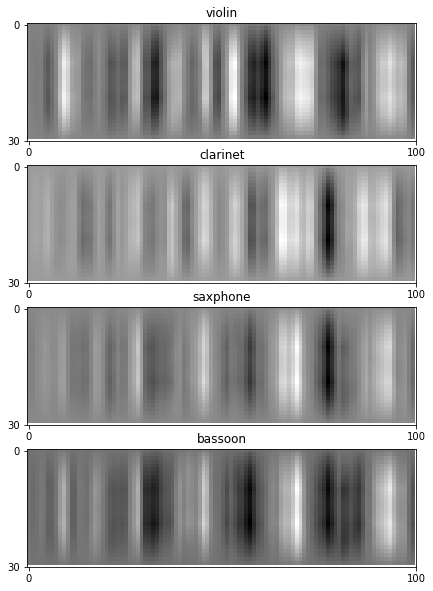

In [25]:
fig, axes = plt.subplots(4, 1, figsize=(20, 10))
sources = ['violin', 'clarinet', 'saxphone', 'bassoon']
for i in range(len(get_grads)):
    g = np.squeeze(get_grads[i](np.ones(input_shape)))
    img = axes[i].imshow(g[:, :100], cmap='gray')
    axes[i].set_title(sources[i])
    axes[i].set_xticks([0, 100])
    axes[i].set_yticks([0, 30])

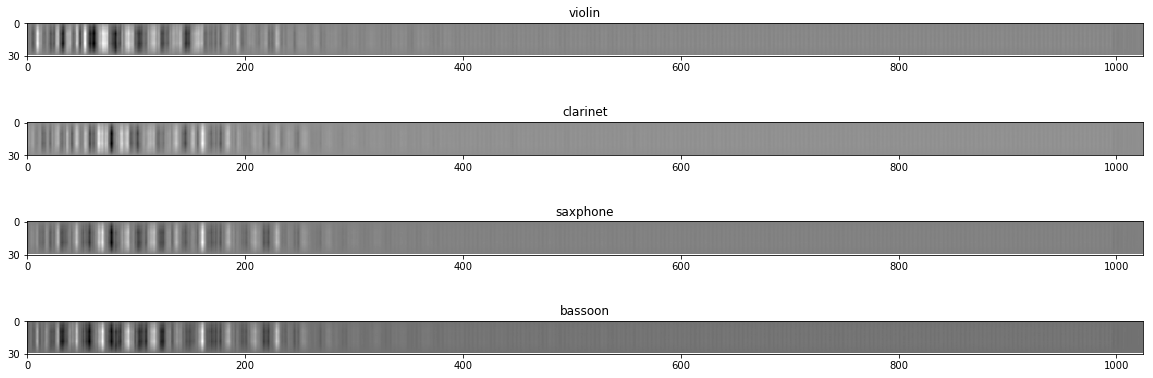

In [20]:
fig, axes = plt.subplots(4, 1, figsize=(20, 7))
sources = ['violin', 'clarinet', 'saxphone', 'bassoon']
for i in range(len(get_grads)):
    g = np.squeeze(get_grads[i](np.ones(input_shape)))
    img = axes[i].imshow(g, cmap='gray')
    axes[i].set_title(sources[i])
    axes[i].set_yticks([30, 0])

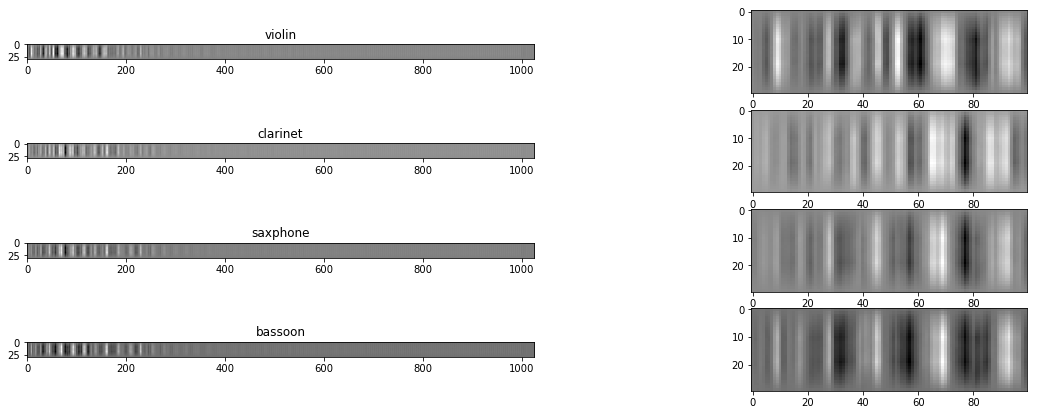

In [15]:
fig, axes = plt.subplots(4, 2, figsize=(20, 7))
sources = ['violin', 'clarinet', 'saxphone', 'bassoon']
for i in range(len(get_grads)):
    g = np.squeeze(get_grads[i](np.ones(input_shape)))
    img = axes[i, 0].imshow(g, cmap='gray')
    img = axes[i, 1].imshow(g[:, :100], cmap='gray')
    axes[i, 0].set_title(sources[i])
    

## Trial 17: feature size 513

In [28]:
batch_size = 1
time_context = 30
feat_size = 513
input_shape=(batch_size,1,time_context,feat_size)
input_var = T.tensor4('inputs')
#scaled_tanh = lasagne.nonlinearities.ScaledTanH(scale_in=1, scale_out=0.5)
    
l_in_1 = lasagne.layers.InputLayer(shape=input_shape, input_var=input_var)

l_conv1 = lasagne.layers.Conv2DLayer(l_in_1, num_filters=30, filter_size=(1,30),stride=(1,4), pad='valid', nonlinearity=None)
l_conv1b= lasagne.layers.BiasLayer(l_conv1)

l_conv2 = lasagne.layers.Conv2DLayer(l_conv1b, num_filters=30, filter_size=(int(2*time_context/3),1),stride=(1,1), pad='valid', nonlinearity=None)
l_conv2b= lasagne.layers.BiasLayer(l_conv2)

l_fc=lasagne.layers.DenseLayer(l_conv2b,256)

l_fc11=lasagne.layers.DenseLayer(l_fc,l_conv2.output_shape[1]*l_conv2.output_shape[2]*l_conv2.output_shape[3])
l_reshape1 = lasagne.layers.ReshapeLayer(l_fc11,(batch_size,l_conv2.output_shape[1],l_conv2.output_shape[2], l_conv2.output_shape[3]))
l_inverse11=lasagne.layers.InverseLayer(l_reshape1, l_conv2)
l_inverse41=lasagne.layers.InverseLayer(l_inverse11, l_conv1)

l_fc12=lasagne.layers.DenseLayer(l_fc,l_conv2.output_shape[1]*l_conv2.output_shape[2]*l_conv2.output_shape[3])
l_reshape2 = lasagne.layers.ReshapeLayer(l_fc12,(batch_size,l_conv2.output_shape[1],l_conv2.output_shape[2], l_conv2.output_shape[3]))
l_inverse12=lasagne.layers.InverseLayer(l_reshape2, l_conv2)
l_inverse42=lasagne.layers.InverseLayer(l_inverse12, l_conv1)

l_fc13=lasagne.layers.DenseLayer(l_fc,l_conv2.output_shape[1]*l_conv2.output_shape[2]*l_conv2.output_shape[3])
l_reshape3 = lasagne.layers.ReshapeLayer(l_fc13,(batch_size,l_conv2.output_shape[1],l_conv2.output_shape[2], l_conv2.output_shape[3]))
l_inverse13=lasagne.layers.InverseLayer(l_reshape3, l_conv2)
l_inverse43=lasagne.layers.InverseLayer(l_inverse13, l_conv1)

l_fc14=lasagne.layers.DenseLayer(l_fc,l_conv2.output_shape[1]*l_conv2.output_shape[2]*l_conv2.output_shape[3])
l_reshape4 = lasagne.layers.ReshapeLayer(l_fc14,(batch_size,l_conv2.output_shape[1],l_conv2.output_shape[2], l_conv2.output_shape[3]))
l_inverse14=lasagne.layers.InverseLayer(l_reshape4, l_conv2)
l_inverse44=lasagne.layers.InverseLayer(l_inverse14, l_conv1)

l_merge=lasagne.layers.ConcatLayer([l_inverse41,l_inverse42,l_inverse43,l_inverse44],axis=1)

l_out = lasagne.layers.NonlinearityLayer(lasagne.layers.BiasLayer(l_merge), nonlinearity=lasagne.nonlinearities.rectify)

In [29]:
model = "../../results/trial_17/models/model_CNNbach10.pkl"
params = load_model(model)
lasagne.layers.set_all_param_values(l_out, params)

In [30]:
get_grads = []
for l in [l_inverse41, l_inverse42, l_inverse43, l_inverse44]:
    pred = lasagne.layers.get_output(l, deterministic=True)
    cost = lasagne.objectives.squared_error(pred, np.zeros(l.output_shape)).sum()
    #all_params = lasagne.layers.get_all_params(l_out)
    #all_grads = T.grad(cost, all_params)
    grad = theano.grad(cost, input_var)
    get_grads.append(theano.function([input_var], grad, allow_input_downcast=True))

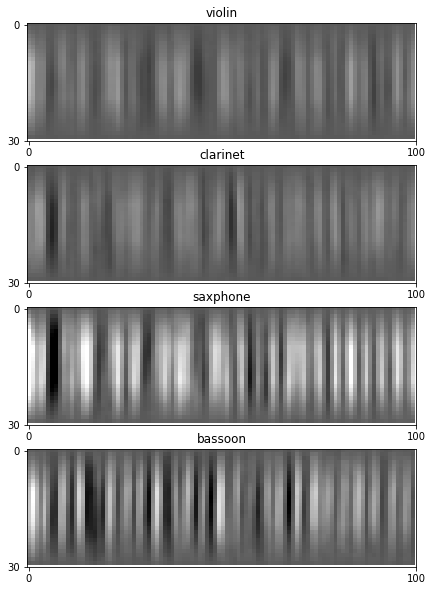

In [43]:
fig, axes = plt.subplots(4, 1, figsize=(20, 10))
sources = ['violin', 'clarinet', 'saxphone', 'bassoon']
vmin = np.inf
vmax = -np.inf
for g in get_grads[i](np.ones(input_shape)):
    g = np.squeeze(g)[:, 200:300]
    if np.min(g) < vmin: vmin = np.min(g)
    if np.max(g) > vmax: vmax = np.max(g)
for i in range(len(get_grads)):
    g = np.squeeze(get_grads[i](np.ones(input_shape)))
    img = axes[i].imshow(g[:, 200:300], cmap='gray', vmin=vmin, vmax=vmax)
    axes[i].set_title(sources[i])
    axes[i].set_xticks([0, 100])
    axes[i].set_yticks([0, 30])

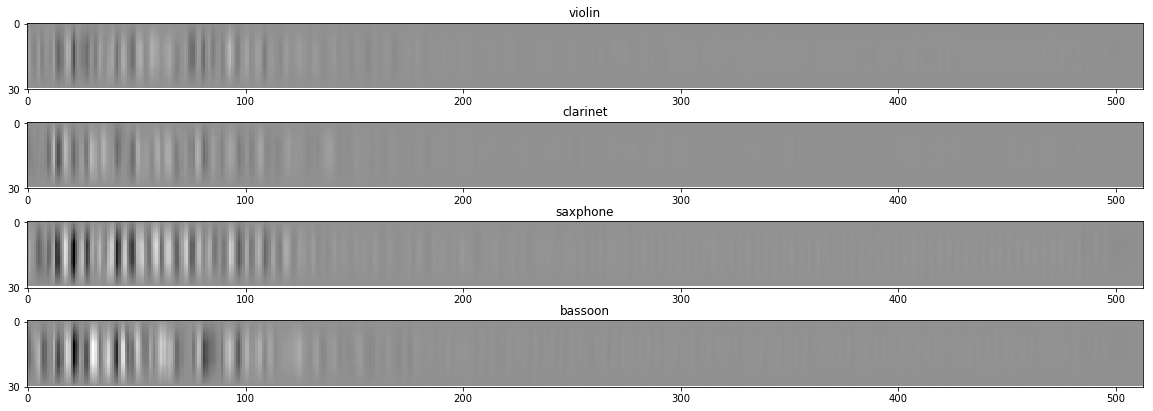

In [45]:
fig, axes = plt.subplots(4, 1, figsize=(20, 7))
sources = ['violin', 'clarinet', 'saxphone', 'bassoon']
for g in get_grads[i](np.ones(input_shape)):
    g = np.squeeze(g)
    if np.min(g) < vmin: vmin = np.min(g)
    if np.max(g) > vmax: vmax = np.max(g)
for i in range(len(get_grads)):
    g = np.squeeze(get_grads[i](np.ones(input_shape)))
    img = axes[i].imshow(g, cmap='gray', vmin=vmin, vmax=vmax)
    axes[i].set_title(sources[i])
    axes[i].set_yticks([30, 0])

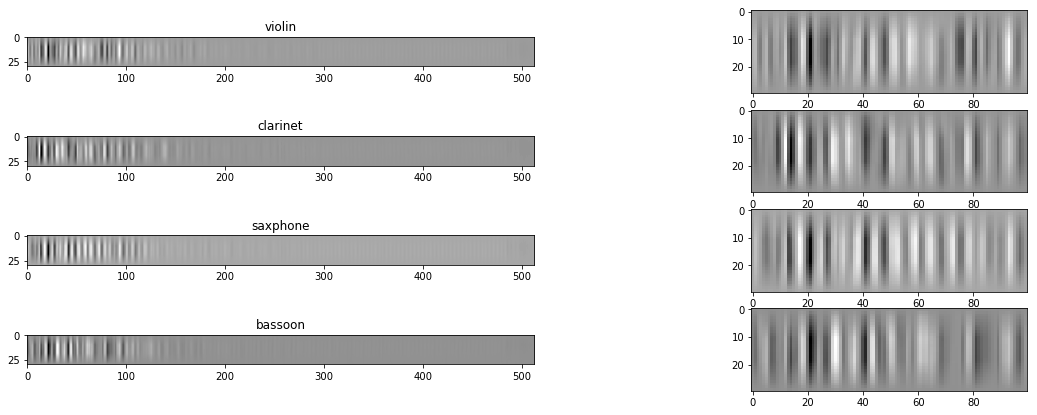

In [33]:
fig, axes = plt.subplots(4, 2, figsize=(20, 7))
sources = ['violin', 'clarinet', 'saxphone', 'bassoon']
for i in range(len(get_grads)):
    g = np.squeeze(get_grads[i](np.ones(input_shape)))
    img = axes[i, 0].imshow(g, cmap='gray')
    img = axes[i, 1].imshow(g[:, :100], cmap='gray')
    axes[i, 0].set_title(sources[i])
    